In [21]:
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import string
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import spacy
from scipy.spatial.distance import cosine
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [22]:
nlp = spacy.load('en_core_web_md') 
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zekinchangmail.com/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

> `python -m spacy download en_core_web_md`  
> `python -m spacy download en_core_web_lg`&emsp;&emsp;&ensp;*optional library*  
> `python -m spacy download en_vectors_web_lg`&emsp;*optional library* 

# Spacey Word Vector

Word vectors - also called word embeddings - are mathematical descriptions of individual words such that words that appear frequently together in the language will have similar values. In this way we can mathematically derive context. The word vector for "lion" will be closer in value to "cat" than to "dandelion". <br>

Since spaCy employs 300 dimensions, word vectors are stored as 300-item arrays using [word2vec](https://en.wikipedia.org/wiki/Word2vec) as family of algorithms.

In [23]:
nlp(u'lion').vector.shape

(300,)

In [24]:
# Doc and Span objects themselves have vectors, from the averages of individual token vectors.
# it is possible to compare similarities between whole documents.
nlp(u'The quick brown fox jumped over the lazy dogs.').vector.shape

(300,)

In [25]:
# compare similarities
# Create a three-token Doc object:
tokens = nlp(u'lion cat dandelion pet')
{(x, y) : x.similarity(y) for x in tokens for y in tokens}

{(lion, lion): 1.0,
 (lion, cat): 0.5265437,
 (lion, dandelion): 0.18064451,
 (lion, pet): 0.39923772,
 (cat, lion): 0.5265437,
 (cat, cat): 1.0,
 (cat, dandelion): 0.22651166,
 (cat, pet): 0.7505456,
 (dandelion, lion): 0.18064451,
 (dandelion, cat): 0.22651166,
 (dandelion, dandelion): 1.0,
 (dandelion, pet): 0.21023153,
 (pet, lion): 0.39923772,
 (pet, cat): 0.7505456,
 (pet, dandelion): 0.21023153,
 (pet, pet): 1.0}

In [26]:
# opposite meaning, but often appear in the same context may have similar vectors.
tokens = nlp(u'like love hate')
{(x, y) : x.similarity(y) for x in tokens for y in tokens}

{(like, like): 1.0,
 (like, love): 0.65790397,
 (like, hate): 0.6574652,
 (love, like): 0.65790397,
 (love, love): 1.0,
 (love, hate): 0.6393099,
 (hate, like): 0.6574652,
 (hate, love): 0.6393099,
 (hate, hate): 1.0}

In [27]:
# total of 20000 vocab 
nlp.vocab.vectors.shape

(20000, 300)

In [28]:
# out of vocab is True if the word not in the corpus
tokens = nlp(u'cat nargle john cheekean')
for token in tokens:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

cat True 6.6808186 False
nargle False 0.0 True
john True 6.533578 False
cheekean False 0.0 True


In [29]:
# Vector arithmetic
new_vector = nlp.vocab['king'].vector - nlp.vocab['man'].vector + nlp.vocab['woman'].vector
sim = 1- cosine(new_vector, nlp.vocab['queen'].vector)
sim

0.7880843877792358

In [30]:
# find other words that is close to the meaning
computed_similarities = []
for word in nlp.vocab:
    # Ignore words without vectors and mixed-case words:
    if word.has_vector & word.is_lower & word.is_alpha:
        similarity = 1- cosine(new_vector, word.vector)
        computed_similarities.append((word, similarity))
# sorted by decending orders
computed_similarities = sorted(computed_similarities, key=lambda item: -item[1])

In [31]:
print([w[0].text for w in computed_similarities[:10]])

['king', 'queen', 'commoner', 'highness', 'prince', 'sultan', 'maharajas', 'princes', 'kumbia', 'kings']


# Word to Vector Embedding

## Manual Training

In [32]:
def my_tokenizer(s):
    '''To tokenize sentence into list'''
    # split string into words (tokens)
    tokens = nltk.tokenize.word_tokenize(s.lower())
    # remove short words, they're probably not useful
    tokens = [t for t in tokens if len(t) > 2] 
    # put words into base form, dogs => dog, jumping => jump
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens] 
    # remove stopwords
    tokens = [t for t in tokens if t not in stopwords.words('english')] 
    # remove punctuction
    tokens = [t for t in tokens if t not in string.punctuation]
    # remove any word with numbers
    tokens = [t for t in tokens if not any(x.isdigit() for x in t)]
    return tokens

def get_token(review):
    '''To update full map of the term in corpus'''
    global word_index_map, current_index
    
    tokens = my_tokenizer(review)
    # update word_map
    for token in tokens:
        if token not in word_index_map:
            word_index_map[token] = current_index
            current_index += 1
    return tokens

def tokens_to_vector(tokens):
    x = np.zeros(len(word_index_map))
    for t in tokens:
        i = word_index_map[t]
        x[i] = 1
    return x

In [33]:
word_index_map = {}
current_index = 0
all_tokens = []
all_titles = []

wordnet_lemmatizer = WordNetLemmatizer()
titles = [line.rstrip() for line in open('./data/all_book_titles.txt')]

In [34]:
for title in titles:
    all_titles.append(title)
    title = title.encode('ascii', 'ignore').decode('utf-8') 
    tokens = get_token(title)
    all_tokens.append(tokens)

In [35]:
N = len(all_tokens)
D = len(word_index_map)
X = np.zeros((D, N))
i = 0
for tokens in all_tokens:
    X[:, i] = tokens_to_vector(tokens)
    i += 1

In [36]:
X.shape

(2149, 2373)

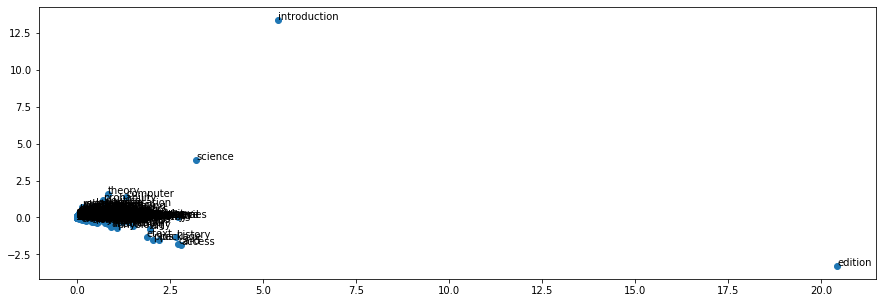

In [37]:
plt.figure(figsize=(15, 5))
svd = TruncatedSVD()
Z = svd.fit_transform(X)
plt.scatter(Z[:,0], Z[:,1])
for i in range(D):
    plt.annotate(s=[x for x in word_index_map.keys()][i], xy=(Z[i,0], Z[i,1]))
plt.show()

In [38]:
df1 = pd.DataFrame()
df1['word'] = word_index_map.keys()
df1 = pd.concat([df1, pd.DataFrame(X, columns=[x for x in range(X.shape[1])])], axis=1)
df1

,word,0,1,2,3,4,5,6,7,8,...,2363,2364,2365,2366,2367,2368,2369,2370,2371,2372
0,philosophy,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,sex,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,love,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,reader,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,reading,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144,nontechnical,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2145,contingency,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2146,chester,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2147,wallace,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Training with Gensim

In [39]:
from gensim.models import Word2Vec

In [40]:
titles = [line.rstrip() for line in open('./data/all_book_titles.txt')]
for title in titles:
    title = title.encode('ascii', 'ignore').decode('utf-8') 
    tokens = get_token(title)
    all_tokens.append(tokens)

In [41]:
model = Word2Vec(all_tokens, min_count=1, size=100, window=5)

In [42]:
# number of vocab
len(model.wv.vocab)

2149

In [43]:
print(model['reader'])

[-0.25699803 -0.00655439  0.05461361  0.17449337  0.03101155 -0.07262624
 -0.03026049  0.08407199  0.08167855  0.26853952 -0.23591188 -0.05501236
 -0.06041348 -0.01560803 -0.08820088  0.00551266 -0.17788956 -0.10415399
 -0.08585376  0.22457552  0.13074954 -0.04392648  0.18491635 -0.1994178
 -0.04311103 -0.10047056 -0.00821255  0.06014597 -0.17590214  0.03794859
  0.00962009  0.07395389  0.00273502 -0.13833748  0.05528268 -0.05854871
  0.09604993 -0.07704677  0.24588796  0.15239567  0.1923423   0.01185525
  0.23565458 -0.08995715 -0.01619632  0.10484279 -0.0353081  -0.00479329
  0.12147496  0.06233717  0.04242137 -0.22133735 -0.1127692   0.07404493
 -0.19836362  0.11499991  0.2350251  -0.0092847   0.05680984 -0.21768121
 -0.04618243  0.30678597  0.10274155  0.13603722  0.12097996  0.00928889
 -0.08109895  0.04980766  0.20117043 -0.16849872 -0.02085104  0.16310874
 -0.14192833  0.07314122  0.17766385 -0.00937262  0.13391617  0.3277991
  0.05455923  0.14133665  0.02871813  0.14311656 -0.2

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


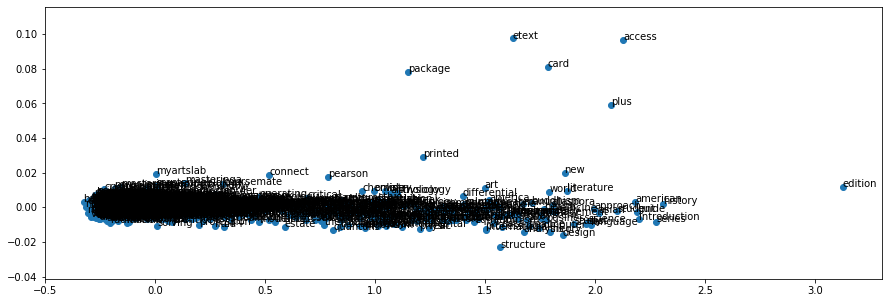

In [44]:
# use PCA to visualize
pca = PCA(n_components=2)
X = model[model.wv.vocab]
result = pca.fit_transform(X)

plt.figure(figsize=(15, 5))
plt.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

## Training with GloVe

## Google’s Word2Vec Embedding

To download Google Model
https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

In [ ]:
from gensim.models import KeyedVectors
filename = 'GoogleNews-vectors-negative300.bin'

In [ ]:
model = KeyedVectors.load_word2vec_format(filename, binary=True)
# calculate: (king - man) + woman = ?
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

#  Sentiment Analysis with Semantics

VADER is an NLTK module that provides sentiment scores based on words used ("completely" boosts a score, while "slightly" reduces it), on capitalization & punctuation ("GREAT!!!" is stronger than "great."), and negations (words like "isn't" and "doesn't" affect the outcome).
<br>To view the source code visit https://www.nltk.org/_modules/nltk/sentiment/vader.html

## Basic

In [185]:
sid = SentimentIntensityAnalyzer()

In [186]:
a = 'This was a good movie.'
sid.polarity_scores(a)

{'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'compound': 0.4404}

In [187]:
a = 'This was the best, most awesome movie EVER MADE!!!'
sid.polarity_scores(a)

{'neg': 0.0, 'neu': 0.425, 'pos': 0.575, 'compound': 0.8877}

In [188]:
a = 'This was the worst film to ever disgrace the screen.'
sid.polarity_scores(a)

{'neg': 0.477, 'neu': 0.523, 'pos': 0.0, 'compound': -0.8074}

## Classification

In [191]:
df = pd.read_csv('./data/amazonreviews.tsv', sep='\t')
df.dropna(inplace=True)
df = df[~df['review'].str.isspace()]
df.head()

,label,review
0,pos,Stuning even for the non-gamer: This sound tra...
1,pos,The best soundtrack ever to anything.: I'm rea...
2,pos,Amazing!: This soundtrack is my favorite music...
3,pos,Excellent Soundtrack: I truly like this soundt...
4,pos,"Remember, Pull Your Jaw Off The Floor After He..."


In [193]:
df['scores'] = df['review'].apply(lambda review: sid.polarity_scores(review))
df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])
df['comp_score'] = df['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')
df.head()

,label,review,scores,compound,comp_score
0,pos,Stuning even for the non-gamer: This sound tra...,"{'neg': 0.088, 'neu': 0.669, 'pos': 0.243, 'co...",0.9454,pos
1,pos,The best soundtrack ever to anything.: I'm rea...,"{'neg': 0.018, 'neu': 0.837, 'pos': 0.145, 'co...",0.8957,pos
2,pos,Amazing!: This soundtrack is my favorite music...,"{'neg': 0.04, 'neu': 0.692, 'pos': 0.268, 'com...",0.9858,pos
3,pos,Excellent Soundtrack: I truly like this soundt...,"{'neg': 0.09, 'neu': 0.615, 'pos': 0.295, 'com...",0.9814,pos
4,pos,"Remember, Pull Your Jaw Off The Floor After He...","{'neg': 0.0, 'neu': 0.746, 'pos': 0.254, 'comp...",0.9781,pos


In [195]:
print(confusion_matrix(df['label'],df['comp_score']))
print(classification_report(df['label'],df['comp_score']))

[[2623 2474]
 [ 435 4468]]
              precision    recall  f1-score   support

         neg       0.86      0.51      0.64      5097
         pos       0.64      0.91      0.75      4903

    accuracy                           0.71     10000
   macro avg       0.75      0.71      0.70     10000
weighted avg       0.75      0.71      0.70     10000



In [7]:
df = pd.DataFrame({'a': ['red', 'yellow', 'blue'], 'b': [0.5, 0.25, 0.125], 'c' : ['22', 'aa', 'cc']})